<a href="https://colab.research.google.com/github/durml91/MMath-Project/blob/duo-branch/Image_Diffusion_(working)/Copy_of_Spiral_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install einops
!pip install equinox
!pip install optax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 802.5 kB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 9.7 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 2.7.1
    Uninstalling typeguard-2.7.1:
      Successfully uninstalled typeguard-2.7.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 KB 13.0 MB/s eta 0:00:00


In [3]:
import array
import functools as ft
import gzip
import os
import struct
import urllib.request

#import diffrax as dfx  # https://github.com/patrick-kidger/diffrax
import einops  # https://github.com/arogozhnikov/einops
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax

import equinox as eqx
import numpy as np

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import optax
# import jax
# import jax.numpy as jnp
# import jax.random as jr
# %matplotlib inline
# import time
# import pylab as pl
# from IPython import display
# from tqdm.notebook import trange, tqdm
# import functools as ft
# import einops

In [4]:
# Data hyper-parameters
N = 1024  # nr of datapoints
vocab_size = 256

# Noise schedule hyper-parameters
beta_min = -8.0  
beta_max = 5.0  

key = jax.random.PRNGKey(seed=2023)
np.random.seed(2023)

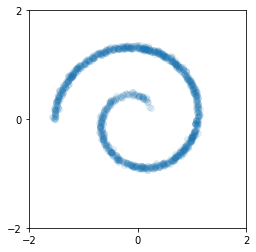

In [5]:
theta = np.sqrt(np.random.rand(N)) * 3 * np.pi  # we generate an array of shape (1024,) such that it they are uniform random numbers in [0,1) and then apply a bunch of operatrions on it
r_a = 0.07 * (2 * theta + np.pi) #mutiply by trig function below by some constant r_a
x = np.array([np.cos(theta) * r_a, np.sin(theta) * r_a]).T #here we produce two rows now of 1024 numbers that have been put through either function respectively - then tranpose so the shape ends up being (1024,2)

x = x + 0.02 * np.random.randn(N, 2) #again we multiply by a bunch of uniform random numbers of the right broadcasting shape

plt.figure().add_subplot(111).set_aspect("equal", adjustable="box")
plt.scatter(x[:, 0], x[:, 1], alpha=0.1) #plot 1st row as x values and 2nd row as y values on the plot
plt.xticks([-2, 0, 2])
plt.yticks([-2, 0, 2])
plt.show()

# Get mean and standard deviation of 'x'
x_mean = x.mean(axis=0)
x_std = x.std(axis=0)

In [6]:
def beta(t):
    b = beta_min
    w = beta_max - beta_min
    return w * t + b

In [7]:
def plot(data, color="blue"):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xticks([-2, 0, 2])
    ax.set_yticks([-2, 0, 2])
    plt.scatter(data[:, 0], data[:, 1], alpha=0.1, c=color)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)

In [8]:
def sample_q_t_x( t, x, key=key):
    t *= jnp.ones((1,)) #convert t to a (1,) dimension array
    var_t = jax.nn.sigmoid(beta(t))[:, None] #jax function to get sigmoid
    eps = jax.random.normal(key, shape=x.shape)
    z_t = jnp.sqrt(1.0 - var_t) * x + jnp.sqrt(var_t) * eps #this is simply the reparamterisation
    return z_t

In [ ]:
# rng1, rng2, rng3, rng4 = jax.random.split(key , 4)

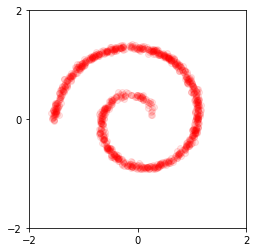

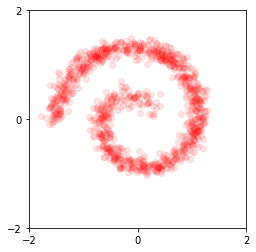

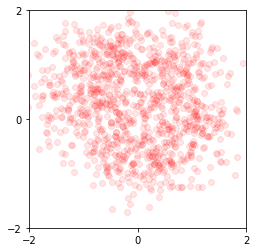

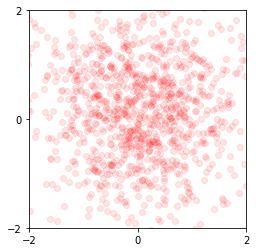

In [ ]:
t=0.0
while t < 1.0:
  plot(sample_q_t_x( t, x, key), color="red")
  t += 0.25

In [ ]:
def log_q_t_z(z, t):
    # t: scalar timestep
    # z: [B, D], points to evaluate on - theis comes from the meshgrid
    # x: [N, D], dataset
    # D: data dimensionality
    # var_t = jax.nn.sigmoid(beta(t))[None, None, None] #simply produces an array of one particular value
    # means_t = jnp.sqrt(1.0 - var_t) * x[None, :, :] 
    var_t = jax.nn.sigmoid(beta(t))
    var_t = einops.rearrange(var_t, "  -> 1 1 1")

    
    nx = einops.rearrange(x, " n d -> 1 n d")
    means_t = jnp.sqrt(1.0 - var_t)*nx

    nz  = einops.rearrange(z, "b d -> b 1 d")
    
    log_q = (nz - means_t) ** 2 / var_t + jnp.log(var_t * 2 * jnp.pi)
    #print(log_q.shape)
    log_q *= -0.5
    
    
    #log_q = log_q.sum(axis=2) 
    log_q = einops.reduce(log_q, "b n d -> b n", "sum")#essentially gets rid of the last dimension
    #print(log_q.shape)

    # Mixture of Gaussians, N is number of mixture components
    N = x.shape[1] #we should just recover our N which was orginally 1024
    log_q = jax.scipy.special.logsumexp(log_q - jnp.log(N), axis=1)

    return log_q


In [ ]:
def plot_density(t):
    k = 100
    _x = jnp.linspace(-2, 2, k)  # , endpoint=False)
    _y = jnp.linspace(-2, 2, k)  # , endpoint=False)
    xs, ys = jnp.meshgrid(_x, _y)
    xys = jnp.vstack([xs.ravel(), ys.ravel()]).T
    q_t_x = jnp.exp(log_q_t_z(xys, t))
    q_t_x = q_t_x.reshape((k, k))

    plt.figure().add_subplot(111).set_aspect("equal", adjustable="box")
    plt.contourf(_x, _y, q_t_x, 20, cmap="Greys")
    plt.xticks([-2, 0, 2])
    plt.yticks([-2, 0, 2])

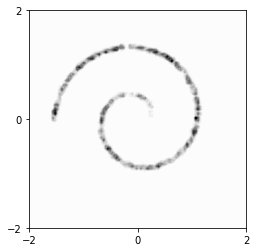

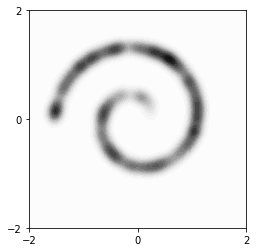

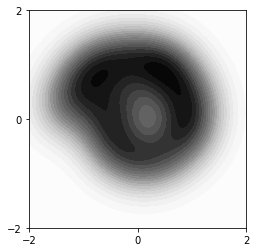

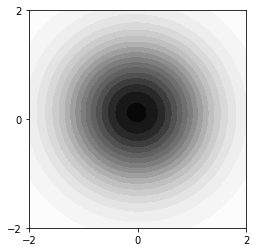

In [ ]:
t=0.0
while t < 1.0:
  plot_density(t)
  t += 0.25

In [ ]:
def plot_quiver(f):
    k = 20
    _x = jnp.linspace(-2, 2, k)  # , endpoint=False)
    _y = jnp.linspace(-2, 2, k)  # , endpoint=False)
    xs, ys = jnp.meshgrid(_x, _y)  #this divides the vectors above nicely into a matrix of rows and columns respescting the dimnesion specified above
    xys = jnp.vstack([xs.ravel(), ys.ravel()]).T #vstack concatenates along the first axis an array that has been reshaped from (N,) to (1,N) - then we transpose it back to (N,1)
    #print(xys.shape)
    gradients = f(xys) #f will be our grad function

    plt.figure().add_subplot(111).set_aspect("equal", adjustable="box")
    plt.quiver(xys[:, 0], xys[:, 1], gradients[:, 0], gradients[:, 1], width=0.005) #recall that we have both the positions in the vector field and the vector/directions which here will be the gradients
    plt.xticks([-2, 0, 2])
    plt.yticks([-2, 0, 2])


In [ ]:
f_score = jax.grad(lambda z, t: log_q_t_z(z, t).sum()) #so we take the grad not of the function log, but of the mapping! Also this is summing over the array of size (400,) so the output is a scalar

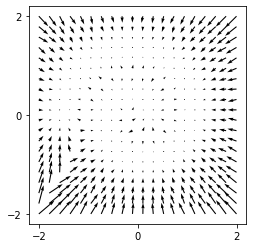

In [ ]:
plot_quiver(ft.partial(f_score, t=0.0))

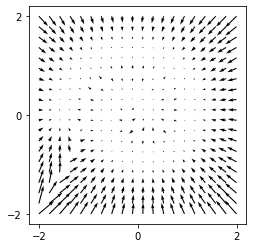

In [ ]:
plot_quiver(ft.partial(f_score, t=0.25))

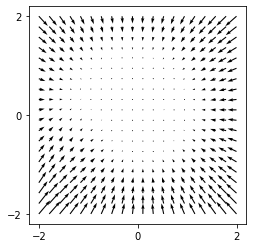

In [ ]:
plot_quiver(ft.partial(f_score, t=0.5))

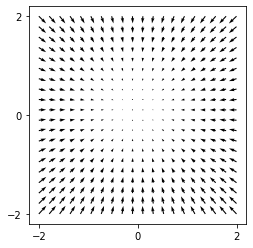

In [ ]:
plot_quiver(ft.partial(f_score, t=0.75))

### ODE variant

In [10]:
!pip install equinox
!pip install optax
!pip install einops
!pip install diffrax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.1/138.1 KB 12.4 MB/s eta 0:00:00


In [11]:
import array
import functools as ft
import gzip
import os
import struct
import urllib.request

import diffrax as dfx  # https://github.com/patrick-kidger/diffrax
import einops  # https://github.com/arogozhnikov/einops
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax

import equinox as eqx
import numpy as np

In [12]:
np.random.seed(2023)
#key = jr.PRNGKey(2023)

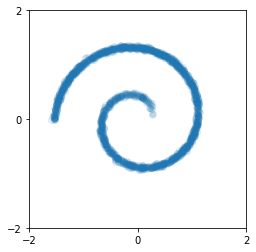

In [13]:
N = 2000

theta = np.sqrt(np.random.rand(N)) * 3 * np.pi  # we generate an array of shape (1024,) such that it they are uniform random numbers in [0,1) and then apply a bunch of operatrions on it
r_a = 0.07 * (2 * theta + np.pi) #mutiply by trig function below by some constant r_a
x = np.array([np.cos(theta) * r_a, np.sin(theta) * r_a]).T #here we produce two rows now of 1024 numbers that have been put through either function respectively - then tranpose so the shape ends up being (1024,2)

x = x + 0.02 * np.random.randn(N, 2) #again we multiply by a bunch of uniform random numbers of the right broadcasting shape

plt.figure().add_subplot(111).set_aspect("equal", adjustable="box")
plt.scatter(x[:, 0], x[:, 1], alpha=0.1) #plot 1st row as x values and 2nd row as y values on the plot
plt.xticks([-2, 0, 2])
plt.yticks([-2, 0, 2])
plt.show()

# Get mean and standard deviation of 'x'
x_mean = x.mean(axis=0)
x_std = x.std(axis=0)

In [14]:
class NeuralNet(eqx.Module):
  main_net: eqx.nn.MLP
  t1: float

  def __init__(self, in_size, out_size, hidden_size, depth, key):
    (rng,) = jr.split(key, 1)
    self.main_net = eqx.nn.MLP(in_size, out_size , hidden_size, depth, key = rng)
    self.t1 = t1

  def __call__(self, t, y):
    t = t / self.t1
    t = einops.repeat(t, "-> 2")
    y = jnp.concatenate([y, t]) #axis =1
    
    y = self.main_net(y)
    return y

In [15]:
def single_loss_fn(model, weight, int_beta, data, t, key):
    mean = data * jnp.exp(-0.5 * int_beta(t))
    var = jnp.maximum(1 - jnp.exp(-int_beta(t)), 1e-5)
    std = jnp.sqrt(var)
    noise = jr.normal(key, data.shape)
    y = mean + std * noise
    pred = model(t, y)
    return weight(t) * jnp.mean((pred + noise / std) ** 2)

In [16]:
def batch_loss_fn(model, weight, int_beta, data, t1, key):
    batch_size = data.shape[0]
    tkey, losskey = jr.split(key)
    losskey = jr.split(losskey, batch_size)
    # Low-discrepancy sampling over t to reduce variance
    t = jr.uniform(tkey, (batch_size,), minval=0, maxval=t1 / batch_size)
    t = t + (t1 / batch_size) * jnp.arange(batch_size)
    loss_fn = ft.partial(single_loss_fn, model, weight, int_beta)
    loss_fn = jax.vmap(loss_fn)
    return jnp.mean(loss_fn(data, t, losskey))

In [17]:
@eqx.filter_jit
def make_step(model, weight, int_beta, data, t1, key, opt_state, opt_update):
    loss_fn = eqx.filter_value_and_grad(batch_loss_fn)
    loss, grads = loss_fn(model, weight, int_beta, data, t1, key)
    updates, opt_state = opt_update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    key = jr.split(key, 1)[0]
    return loss, model, key, opt_state


In [18]:
t1=10.0
# Optimisation hyperparameters
num_steps=1_000_000
lr=3e-4
batch_size=256
print_every=1_000
# Sampling hyperparameters
dt0=0.1
#sample_size=10
# Seed
seed=2023

In [19]:
key = jr.PRNGKey(seed)
#model_key, train_key, loader_key, sample_key = jr.split(key, 4)

In [ ]:
# data = x
# data_shape = data.shape[1:]

In [ ]:
# model = NeuralNet(4, 2, 512, 4, key)

In [ ]:
# int_beta = lambda t: t
# weight = lambda t: 1 - jnp.exp(-int_beta(t))

In [ ]:
# opt = optax.adabelief(lr)
# opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))

In [20]:
def dataloader(data, batch_size, *, key):
    dataset_size = data.shape[0]
    indices = jnp.arange(dataset_size)
    while True:
        perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield data[batch_perm, :]
            start = end
            end = start + batch_size

In [ ]:
# total_value = 0
# total_size = 0
# for step, data in zip(range(num_steps), dataloader(data, batch_size, key=loader_key)):
#         value, model, train_key, opt_state = make_step(model, weight, int_beta, data, t1, train_key, opt_state, opt.update)
#         total_value += value.item()
#         total_size += 1
#         if (step % print_every) == 0 or step == num_steps - 1:
#             print(f"Step={step} Loss={total_value / total_size}")
#             total_value = 0
#             total_size = 0

In [43]:
def train():

  model_key, train_key, loader_key, sample_key = jr.split(key, 4)
  data = x
  data_shape = data.shape[1:]

  model = NeuralNet(4, 2, 512, 4, key)


  int_beta = lambda t: t
  weight = lambda t: 1 - jnp.exp(-int_beta(t))  
  opt = optax.adabelief(lr)
  opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))

  total_value = 0
  total_size = 0
  losses = [0]
  i=0
  ls=2


  for step, data in zip(range(num_steps), dataloader(data, batch_size, key=loader_key)):
          value, model, train_key, opt_state = make_step(model, weight, int_beta, data, t1, train_key, opt_state, opt.update)
          total_value += value.item()
          total_size += 1

          if (step % print_every) == 0 or step == num_steps - 1:
              
              print(f"Step={step} Loss={total_value / total_size}")
              if step != 0 :
                ls = total_value / total_size
                if jnp.absolute(ls - losses[i]) > 1e-5:
                  i += 1
                  losses.append(ls)
                else:
                  print("Early stopping intervened")
                  break
              else:
                continue
              total_value = 0
              total_size = 0


  return model
  # sample_key = jr.split(sample_key, 1_000)
  # sample_fn = ft.partial(single_sample_fn, model, int_beta, data_shape, dt0, t1)
  # sample = jax.vmap(sample_fn)(sample_key)
  
  # plt.figure().add_subplot(111).set_aspect("equal", adjustable="box")
  # plt.scatter(sample[:, 0], sample[:, 1], alpha=0.1) #plot 1st row as x values and 2nd row as y values on the plot
  # plt.axis("off")
  # plt.xticks([-2, 0, 2])
  # plt.yticks([-2, 0, 2])
  # plt.show()

In [ ]:
model = train()

In [39]:
int_beta = lambda t: t

In [37]:
data_shape = x.shape[1:]

In [101]:
@eqx.filter_jit
def single_sample_fn(model, int_beta, data_shape, dt0, t1, key):
    def drift(t, y, args):
        _, beta = jax.jvp(int_beta, (t,), (jnp.ones_like(t),))
        return -0.5 * beta * (y + model(t, y))

    term = dfx.ODETerm(drift)
    solver = dfx.Tsit5()
    t0 = 0.025
    y1 = jr.normal(key, data_shape)
    # reverse time, solve from t1 to t0
    sol = dfx.diffeqsolve(term, solver, t1, t0, -dt0, y1, adjoint=dfx.NoAdjoint())
    return sol.ys[0]

In [102]:
sample_key = jr.split(key, 2_000)
sample_fn = ft.partial(single_sample_fn, model, int_beta, data_shape, dt0, t1)
sample = jax.vmap(sample_fn)(sample_key)

In [46]:
sample.shape

(1000, 2)

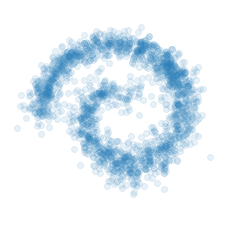

In [103]:
plt.figure().add_subplot(111).set_aspect("equal", adjustable="box")
plt.scatter(sample[:, 0], sample[:, 1], alpha=0.1) #plot 1st row as x values and 2nd row as y values on the plot
plt.axis("off")
plt.xticks([-2, 0, 2])
plt.yticks([-2, 0, 2])
plt.show()

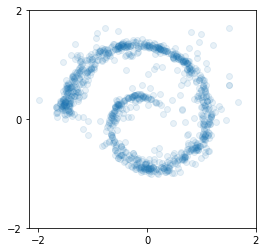

In [ ]:
plt.figure().add_subplot(111).set_aspect("equal", adjustable="box")
plt.scatter(sample[:, 0], sample[:, 1], alpha=0.1) #plot 1st row as x values and 2nd row as y values on the plot
plt.xticks([-2, 0, 2])
plt.yticks([-2, 0, 2])
plt.show()

## SDE attempt

In [ ]:
# from jax.lax import scan

In [ ]:
# def reverse_sde(model, int_beta, data_shape, tsample, n_samples, key):
 
#     def f(carry, params):
#         t, dt = params
#         x, rng = carry
#         rng, step_rng = jr.split(rng)
#         disp = jnp.sqrt(int_beta(1-t))
#         t = jnp.ones((x.shape[0], 1)) * t
#         fdr = 0.5*int_beta(1-t)*x
#         print(x.shape)
#         drift = fdr + disp**2 * model(x, 1-t)
#         noise = jr.normal(step_rng, x.shape)
#         x = x + dt * drift + jnp.sqrt(dt)*disp*noise
#         return (x, rng), ()
    
#     rng, step_rng = jr.split(key, 2)
#     initial = jr.normal(step_rng, (n_samples, data_shape[0]))
#     ts = jnp.arange(1, tsample)/(tsample-1)
    
#     dts = ts[1:] - ts[:-1]
#     params = jnp.stack([ts[:-1], dts], axis=1)
#     print(params.shape)
#     sampletest = ft.partial(f, (initial, rng))
#     sample = jax.vmap(sampletest)(params)
#     return x

In [ ]:
# testsamples = reverse_sde(model, int_beta, data_shape, 1000, 1000, key)

In [ ]:
# from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree
# def drift(model, x, t):
#   a = 0.5 * t * x
#   c = a + jnp.sqrt(t)**2 * model(x, t)
# t0, t1 = 0.01, 10
# #drift = lambda t, x, args : 0.5*t*x
# diffusion = lambda t, x, args: jnp.sqrt(t)
# brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape=(), key=jr.PRNGKey(2023))
# terms = MultiTerm(ODETerm(drift), ControlTerm(diffusion, brownian_motion))
# solver = Euler()
# saveat = SaveAt(dense=True)

# dt0=-0.05
# y0=jr.normal(key, (1,))

# sol = diffeqsolve(terms, solver, t1, t0, dt0, y0, saveat=saveat)
# print(sol.evaluate(t1))  # DeviceArray(0.89436394)

In [ ]:
# import jax.random as jrandom
# from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree

# tree=jr.PRNGKey(0)

# t0, t1 = .1, 10
# drift = lambda t, y, args: -y
# diffusion = lambda t, y, args: 0.1 * t
# brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape=(), key=jr.PRNGKey(0))
# terms = MultiTerm(ODETerm(drift), ControlTerm(diffusion, brownian_motion))
# solver = Euler()
# saveat = SaveAt(dense=True)
# y0 = jr.normal(tree, (1,))
# dt0 = -0.05
# sol = diffeqsolve(terms, solver, t1, t0, dt0, y0, saveat=saveat)
# print(sol.evaluate(t1))  # DeviceArray(0.89436394)

In [ ]:
from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree, UnsafeBrownianPath, NoAdjoint

In [ ]:
@eqx.filter_jit
def single_sample_fn(model, int_beta, data_shape, dt0, t1, key):
  
  def drift(t, y, args):
    _, beta = jax.jvp(int_beta, (t,), (jnp.ones_like(t),))
    return -0.5*beta*(y+2*model(t,y))

  def diffusion(t, y, args):
    _, beta = jax.jvp(int_beta, (t,), (jnp.ones_like(t),)) # gets an array of beta_t applied to an array of shape t
    #betat = einops.repeat(beta, "a -> 28 a").shape  - not a "normal" array - cannot use einops
    b = jnp.ones((2,))
    sqrtbeta= jnp.sqrt(beta)
    bet = jax.numpy.outer(sqrtbeta, b)
    return bet
  
  t0=0
  brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape = (2,), key=key)
  y1 = jr.normal(key, data_shape)
  terms = MultiTerm(ODETerm(drift), ControlTerm(diffusion, brownian_motion))
  solver = Euler()

  sol = diffeqsolve(terms, solver, t1, t0, -dt0, y1)
  return sol.ys[0]

In [ ]:
def train():

  model_key, train_key, loader_key, sample_key = jr.split(key, 4)
  data = x
  data_shape = data.shape[1:]

  model = NeuralNet(4, 2, 512, 4, key)


  int_beta = lambda t: t
  weight = lambda t: 1 - jnp.exp(-int_beta(t))  
  opt = optax.adabelief(lr)
  opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))

  total_value = 0
  total_size = 0
  losses = [0]
  i=0
  ls=2


  for step, data in zip(range(num_steps), dataloader(data, batch_size, key=loader_key)):
          value, model, train_key, opt_state = make_step(model, weight, int_beta, data, t1, train_key, opt_state, opt.update)
          total_value += value.item()
          total_size += 1

          if (step % print_every) == 0 or step == num_steps - 1:
              
              print(f"Step={step} Loss={total_value / total_size}")
              if step != 0 :
                ls = total_value / total_size
                if jnp.absolute(ls - losses[i]) > 5e-5:
                  i += 1
                  losses.append(ls)
                else:
                  print("Early stopping intervened")
                  break
              else:
                continue
              total_value = 0
              total_size = 0


  sample_key = jr.split(sample_key, 1_000)
  sample_fn = ft.partial(single_sample_fn, model, int_beta, data_shape, dt0, t1)
  sample = jax.vmap(sample_fn)(sample_key)
  
  plt.figure().add_subplot(111).set_aspect("equal", adjustable="box")
  plt.scatter(sample[:, 0], sample[:, 1], alpha=0.1) #plot 1st row as x values and 2nd row as y values on the plot
  plt.xticks([-2, 0, 2])
  plt.yticks([-2, 0, 2])
  plt.show()

Step=0 Loss=1.0422227382659912
Step=1000 Loss=0.08533594429076134
Step=2000 Loss=0.07559096134081483
Step=3000 Loss=0.0747752986624837
Step=4000 Loss=0.07451099967956543
Step=5000 Loss=0.07354138354584575
Step=6000 Loss=0.07333401926234365
Step=7000 Loss=0.07329040276631713
Early stopping intervened


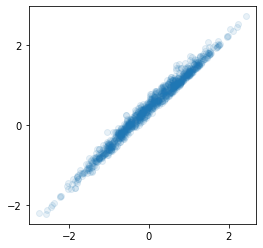

In [ ]:
train()